<center>
<h1>CSCI4155 - 2021/2022 Winter</h1>
<h1>Group Project</h1>
Group 10<br>
Archer Zhou, B00806294<br>
Junqiao Qu, B00817232<br>
Yilong Su, B00837331<br>
</center>

## P1: Data Ready

This is a dataset containing images crawled from BING. The dataset contains 10 animal species, butterfly, cat, chicken, cow, dog, elephant, horse, sheep, spider, squirrel. Each species contains 229 images. 1-150 are original images after compression. And 151-224 are images with salt and pepper noise (with compression). And 225-229 are random images, which do not belong to this species. We use the keyword for search engineer, for ground truth. That is, all images in a folder are considered to belong to this species.


The dataset has the same format as Animal10 (dataset in the proposal). And it has much better image quality and relevance than Animal10. If this turns out to be too easy, we could add more lower-quality images to the dataset, which is closer to the real situation. It can make our network more robust and improve the generalization ability. 

### Section 1. Data Path Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import pathlib
from tqdm import tqdm
import shutil
import torch
import torchvision
from torch.utils import data
from torchvision import transforms, datasets
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Convert folder names of different categories in the dataset to common words.
translates = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", 
             "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", 
             "mucca": "cow", "pecora": "sheep", "ragno" : "spider", "scoiattolo": "squirrel"}

labels = ["cat", "butterfly", "dog", "sheep", "spider", "elephant", "horse", "squirrel", "cow", "chicken"]

original_folder_path = './drive/MyDrive/Courses/CSCI4155-Machine Learning/project/archive/raw-img/'
synthetic_folder_path = './drive/MyDrive/Courses/CSCI4155-Machine Learning/project/GoogleImgCrawler/'
train_folder_path = './drive/MyDrive/Courses/CSCI4155-Machine Learning/project/animals/train/'
test_folder_path = './drive/MyDrive/Courses/CSCI4155-Machine Learning/project/animals/test/'
splited_folder_path = './drive/MyDrive/Courses/CSCI4155-Machine Learning/project/animals/'

animals = os.listdir('./drive/MyDrive/Courses/CSCI4155-Machine Learning/project/GoogleImgCrawler/')
print(animals)

['cat', 'butterfly', 'dog', 'sheep', 'spider', 'elephant', 'horse', 'squirrel', 'cow', 'chicken']


### Section 2. Exploratory Data Analysis

#### 2.1: Loading Dataset & Image Resize

Since some of the images contained in the dataset are of different sizes, we should set up a basic uniform size for all the images while loading the data, which will going to be the input to the model.

In [ ]:
'''
Since the two dataset has the different folder structures,
then write two separate functions.
'''
def loadingOriginalData(dataset_folder_path, img_size):
  animals_dataset = []
  for category, translate in translates.items():
    path = dataset_folder_path + category
    target = animals.index(translate)
            
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img))
        new_img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        new_img_array = cv2.resize(img_array, img_size)
        animals_dataset.append([new_img_array, target])
      except Exception as e:
        pass
  
  return animals_dataset

def loadingSyntheticData(dataset_folder_path, img_size):
  animals_dataset = []
  for category in animals:
    path = dataset_folder_path + category
    target = animals.index(category)
            
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img))
        new_img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        new_img_array = cv2.resize(img_array, img_size)
        animals_dataset.append([new_img_array, target])
      except Exception as e:
        pass
  
  return animals_dataset

def splitDatasetFolder(folder_path, train_folder_path, test_folder_path):
  os.mkdir(splited_folder_path)

  # Create train data folders
  os.mkdir(train_folder_path)
  for img_label in os.listdir(folder_path):
    os.mkdir(train_folder_path + img_label + '/')

  # Create test data folders
  os.mkdir(test_folder_path)
  for img_label in os.listdir(folder_path):
    os.mkdir(test_folder_path + img_label + '/')

  # Form train dataset from original dataset into just created folder structure
  for img_label in tqdm(os.listdir(train_folder_path)):
    img_ls = os.listdir(folder_path + img_label)
    for img in img_ls[:int(len(img_ls) * 0.8)]:
      shutil.copy(folder_path + img_label + '/' + img, 
                      train_folder_path + img_label + '/' + img)
      
  # Form test dataset from original dataset into just created folder structure
  for img_label in tqdm(os.listdir(test_folder_path)):
    img_ls = os.listdir(folder_path + img_label)
    for img in img_ls[int(len(img_ls) * 0.8):]:
      shutil.copy(folder_path + img_label + '/' + img, 
                    test_folder_path + img_label + '/' + img)

In [ ]:
IMAGE_SIZE = (256, 256)
dataset = loadingSyntheticData(synthetic_folder_path, IMAGE_SIZE)

In [ ]:
# Output the dataset's info
print ("Number of training examples: {}".format(len(x_train)))
print ("Number of testing examples: {}".format(len(x_test)))
print("Shape of image data", np.array(x_train).shape)
print("Shape of image label", np.array(y_train).shape)
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 1061
Number of testing examples: 266
Shape of image data (1061, 256, 256, 3)
Shape of image label (1061,)
Each image is of size: (256, 256)


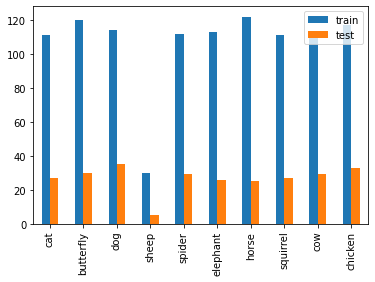

In [ ]:
# Show up the proportion of each observed category
_, train_counts = np.unique(y_train, return_counts=True)
_, test_counts = np.unique(y_test, return_counts=True)
pd.DataFrame({'train': train_counts, 'test': test_counts}, index=labels).plot.bar()
plt.show()

#### 2.2: Data Normalizaiton

When using the image as-is and passing it through the neural network, the computation of high values can become more complicated. To reduce this, we can normalize the values to a range from 0 to 1.

This way, the numbers will be small and the calculation becomes easier and faster. Since the range of pixel values is 0 to 256, except for 0, the range is 255. therefore, dividing all values by 255 will convert them to a range of 0 to 1.

In [ ]:
x_train_norm = np.divide(dataset[0], 255)
x_test_norm = np.divide(dataset[0], 255)

print(x_test_norm[0, 0, 0, 0])

1.0


#### 2.3: Visualize Some Iamges

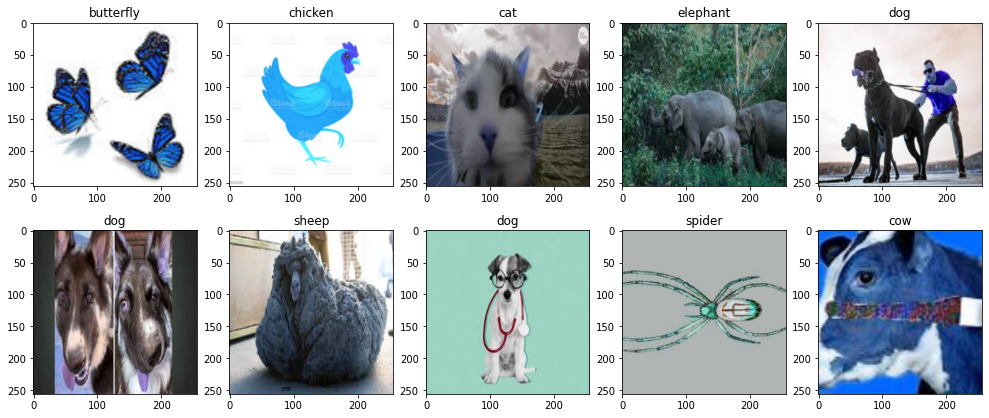

In [ ]:
def visualizeSomeImgs(data):
  labels_map = {0: "cat", 1: "butterfly", 2: "dog", 3: "sheep",
    4: "spider", 5: "elephant", 6: "horse", 7: "squirrel", 8: "cow", 9: "chicken",}

  figure = plt.figure(figsize=(17, 7))
  cols, rows = 5, 2
  for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(data), size=(1,)).item()
    img, label = data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.imshow(img)
  plt.show()

visualizeSomeImgs(dataset)

#### 2.4: Image Augmentataion

Deliberately introducing flaws/Adding noise in our dataset is critical to making our machine learning models more adaptable to the harsh realities they encounter in the real world. In other words, which could make the network is less able to memorize training samples because they are changing all the time, resulting in smaller network weights and a more robust network that has lower generalization error. In practice, there are various types of image defects, such as blur, poor contrast, noise, JPEG compression, and so on. Among them, blur is the most harmful.

According to this, we will consider three cases: compression, noise, and blurring. Like add the Salt and Pepper noise to some images in the dataset. And randomly put some irrelevant images to each category. It is synthetic label noise.

##### 2.4.1: Adding noise

In [ ]:
def gasuss_noise(image, mean=0, var=0.001):
    image = np.array(image / 255, dtype=float)
    noise = np.random.normal(mean, var ** 0.5, image.shape)
    out = image + noise
    if out.min() < 0:
        low_clip = -1.
    else:
        low_clip = 0.
    out = np.clip(out, low_clip, 1.0)
    out = np.uint8(out * 255)

    return out

def sp_noise(image, prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape, np.uint8)
    thres = 1 - prob
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

def addnoise():
    animalList = ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'spider', 'squirrel', 'sheep', 'horse']
    dataset_withNoise = []

    num_range = 75
    for animal in animalList:
      if animal == "sheep": 
        num_range = 15
      else:
        num_range = 75
        for i in range(0, num_range):
            img = cv2.imread(synthetic_folder_path + animal + "/" + str(i) + ".jpg", 1)
            img= sp_noise(img, 0.05)
            img = cv2.resize(img, IMAGE_SIZE)
            dataset_withNoise.append([img, animalList.index(animal)])
            cv2.imwrite(synthetic_folder_path + animal + "/" + str(i + 150) + ".jpg", img, [cv2.IMWRITE_JPEG_QUALITY, 20])

        print(animal, "Finished")
    return dataset_withNoise

In [ ]:
dataset_withNoise = addnoise()

butterfly Finished
cat Finished
chicken Finished
cow Finished
dog Finished
elephant Finished
spider Finished
squirrel Finished
horse Finished


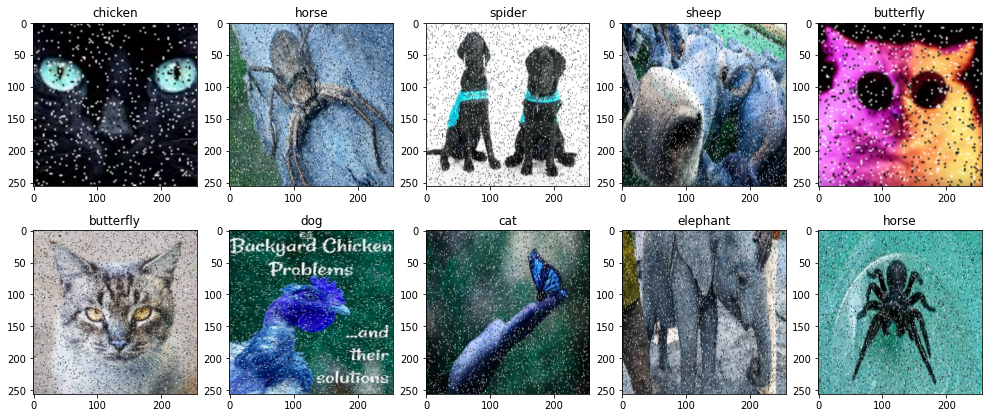

In [ ]:
visualizeSomeImgs(dataset_withNoise)

In [ ]:
# Check the image's shape
print(dataset[0][0].shape)
print(dataset_withNoise[0][0].shape)
print("Number of dataset:", len(dataset))
print("Number of dataset with noise:", len(dataset_withNoise))

(256, 256, 3)
(256, 256, 3)
Number of dataset: 1327
Number of dataset with noise: 675


In [ ]:
dataset_all = dataset_withNoise.copy()

for item in dataset:
  dataset_all.append(item)

print("Number of dataset with noise:", len(dataset_all))
#x_train_noise, x_test_noise, y_train_noise, y_test_nise = datasetSplit(dataset_withNoise)

Number of dataset with noise: 2002


##### 2.4.2: Bluring Image

When we blur an image, we make the color transition from one side of an edge in the image to another smooth rather than sudden. The effect is to average out rapid changes in pixel intensity. There are several different blurring functions in practice, so we will focus on just one here, the Gaussian blur.

So **kernel size** could be one of controlling parameters.

##### 2.4.3: Compressing

In [ ]:
def compress():
    animalList = ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'spider', 'squirrel', 'sheep', 'horse']

    for animal in animalList:
        if not os.path.exists(animal): os.makedirs(animal)
        for i in range(1, 151):
            img = cv2.imread("./raw/" + animal + "/" + str(i) + ".jpg", 1)
            cv2.imwrite("./" + animal + "/" + str(i) + ".jpg", img, [cv2.IMWRITE_JPEG_QUALITY,20])
        print(animal, "Finished")

## P2: Model Ready and Trained

### Section 1. Model Building

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt

In [ ]:
splitDatasetFolder(synthetic_folder_path, train_folder_path, test_folder_path)

100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


In [ ]:
# Prepare the added noise dataset into Tensor format:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(IMAGE_SIZE[0]),
        transforms.RandomCrop(IMAGE_SIZE[0]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(IMAGE_SIZE[0]),
        transforms.CenterCrop(IMAGE_SIZE[0]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(splited_folder_path, x), data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True)
              for x in ['train', 'test']}

train_loader = dataloaders['train']
test_loader = dataloaders['test']

In [ ]:
for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64


#### 1.1: Convolutional Neural Network (CNN)

The convolutional neural network model is chosen here as a simple model with the following structure:

Conv2d (input channels=3, output channels = 15,kernel size = 5)
$\rightarrow$
MaxPool (kernel size = 2)
$\rightarrow$
ReLU
$\rightarrow$
Conv2d (input channels=15, output channels = 30,kernel size = 5)
$\rightarrow$
Dropout2d (p = 0.5)
$\rightarrow$
MaxPool (kernel size = 2)
$\rightarrow$
ReLU
$\rightarrow$
Linear(input dimension = 480, hidden units = 64)
$\rightarrow$
ReLU
$\rightarrow$
Dropout (p=0.5)
$\rightarrow$
Linear(input dimension = 64, hidden units = 10)
$\rightarrow$
LogSoftMax

In [ ]:
class NetWork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 15, 5)       
        self.pool = nn.MaxPool2d(2)    
        self.conv2 = nn.Conv2d(15, 30, 5)     
        self.drop = nn.Dropout2d(p=0.5)            
        self.liner1 = nn.Linear(111630, 64)            
        self.liner2 = nn.Linear(64, 10)
        
    def forward(self,x):
        # Size of input
        in_size = x.size(0)
        
        # step by step as following 
        out = self.conv1(x) 
        out = self.pool(out)
        out = F.relu(out)
        out = self.conv2(out) 
        out = self.drop(out)
        out = self.pool(out)
        out = F.relu(out)
        out = out.view(in_size,-1)
        out = self.liner1(out)
        out = F.relu(out)
        out = self.drop(out)
        out = self.liner2(out)
        out = F.log_softmax(out,dim=1)
        
        return out

In [ ]:
model = NetWork()
print(model)

NetWork(
  (conv1): Conv2d(3, 15, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(15, 30, kernel_size=(5, 5), stride=(1, 1))
  (drop): Dropout2d(p=0.5, inplace=False)
  (liner1): Linear(in_features=111630, out_features=64, bias=True)
  (liner2): Linear(in_features=64, out_features=10, bias=True)
)


In [ ]:
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Sectin 2. Training & Evaluation

In [ ]:
trainLossRecords = []
testLossRecords = []
correctRateRecoeds = []

EPOCHS = 15

for epoch in range(1, EPOCHS + 1):

    model.train()
    
    # Extract data in order
    for batchId, (data, target) in enumerate(train_loader):
        
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fun(output, target)
        trainLossRecords.append(loss)
        loss.backward()
        optimizer.step()
        
        # print information
        if(batchId+1)%60 == 0:
            print('Train Epoch %-3d: [%-3d/%-3d ]\tLoss: %-7.5f'%(epoch, batchId * len(data), len(train_loader.dataset), loss.item()))
                
    
    # Start test
    
    # start evalution mode
    model.eval()
    
    # loss value all
    testLoss = 0
    
    # the number of correct
    correct = 0
    
    # no gradient update
    with torch.no_grad():
        for data, target in test_loader:      
            # get output
            output = model(data)
            
            # sum loss value
            loss = F.nll_loss(output, target, reduction='sum').item()
            testLoss += loss
            
            # predict
            pred = output.max(1, keepdim=True)[1] 
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    correctRate = 100. * correct / len(test_loader.dataset)
    testLoss /= len(test_loader.dataset)
    testLossRecords.append(testLoss)
    correctRateRecoeds.append(correctRate)
    print('Test Epoch %d : Average loss: %-7.5f, Accuracy: %-7d/%-7d = %-7.1f'%(epoch,testLoss, correct, len(test_loader.dataset),correctRate)+"%")

Test Epoch 1 : Average loss: 2.23713, Accuracy: 59     /403     = 14.6   %
Test Epoch 2 : Average loss: 2.20049, Accuracy: 68     /403     = 16.9   %
Test Epoch 3 : Average loss: 2.18038, Accuracy: 76     /403     = 18.9   %
Test Epoch 4 : Average loss: 2.14551, Accuracy: 92     /403     = 22.8   %
Test Epoch 5 : Average loss: 2.11934, Accuracy: 80     /403     = 19.9   %
Test Epoch 6 : Average loss: 2.10416, Accuracy: 95     /403     = 23.6   %
Test Epoch 7 : Average loss: 2.07520, Accuracy: 88     /403     = 21.8   %
Test Epoch 8 : Average loss: 2.03346, Accuracy: 119    /403     = 29.5   %
Test Epoch 9 : Average loss: 2.03686, Accuracy: 126    /403     = 31.3   %
Test Epoch 10 : Average loss: 2.00432, Accuracy: 120    /403     = 29.8   %
Test Epoch 11 : Average loss: 2.00125, Accuracy: 97     /403     = 24.1   %
Test Epoch 12 : Average loss: 1.95068, Accuracy: 139    /403     = 34.5   %
Test Epoch 13 : Average loss: 1.95192, Accuracy: 129    /403     = 32.0   %
Test Epoch 14 : Avera

In [ ]:
# Saving the model
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [ ]:
def Display(data,xCol,title,xlabel,ylabel):
    plt.figure(figsize=(12,5))
    plt.plot(xCol,data,alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

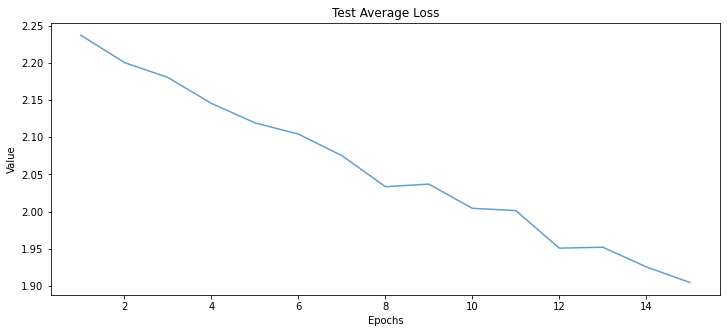

In [ ]:
Display(
    data=testLossRecords,
    xCol=range(1,len(testLossRecords)+1),
    title="Test Average Loss",
    xlabel="Epochs",
    ylabel="Value",
)

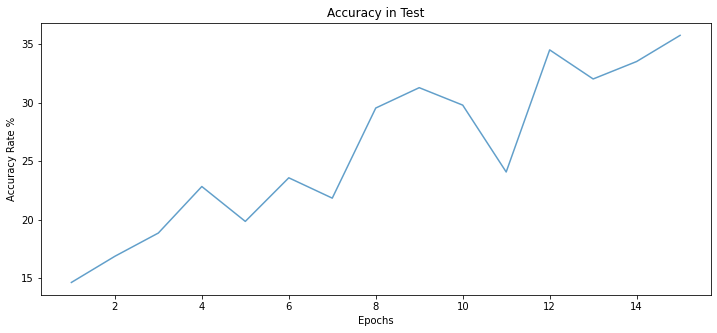

In [ ]:
Display(
    data=correctRateRecoeds,
    xCol=range(1,len(correctRateRecoeds)+1),
    title="Accuracy in Test",
    xlabel="Epochs",
    ylabel="Accuracy Rate %",
)

## P3: Experiment on CNN achitecture & AlexNet & VGG

environmment check

In [ ]:
!/opt/bin/nvidia-smi

Sun Apr 10 18:57:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Section 1: Data Processing

#### 1.1: Environment Setup

In [1]:
import os
import random
import cv2
import numpy as np
import pandas as pd

from tqdm import tqdm
import shutil


import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#April 9
import os
os.chdir('./drive/My Drive/')

#### 1.2: Data Loading

In [ ]:
IMAGE_SIZE = (224, 224)
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "ragno": "spider"}
translate={v: k for k, v in translate.items()}
animals = ["cat", "butterfly", "dog", "sheep", "spider", "elephant", "horse", "squirrel", "cow", "chicken"]
CLASS_DEFINE={"cat":0, "butterfly":1, "dog":2, "sheep":3, "spider":4, "elephant":5, "horse":6, "squirrel":7, "cow":8, "chicken":9}
imgs, label = [], []

for animal in animals:

  print(animal)
  for image in os.listdir("./4155data/raw-img/"+translate[animal]):
    img_array = cv2.imread("./4155data/raw-img/"+translate[animal]+"/"+image)
    
    new_img_array = cv2.resize(img_array, IMAGE_SIZE)
    new_img_array = cv2.cvtColor(new_img_array, cv2.COLOR_BGR2RGB)
    imgs.append(new_img_array)
    label.append(CLASS_DEFINE[animal])

        


cat
butterfly
dog
sheep
spider
elephant
horse
squirrel
cow
chicken


In [ ]:
#save kaggle data
np.save('./4155data/imgs_animal10.npy',imgs)
np.save('./4155data/label_animal10.npy',label)

In [ ]:
#April 9

IMAGE_SIZE = (224, 224)
animals = ["cat", "butterfly", "dog", "sheep", "spider", "elephant", "horse", "squirrel", "cow", "chicken"]
CLASS_DEFINE={"cat":0, "butterfly":1, "dog":2, "sheep":3, "spider":4, "elephant":5, "horse":6, "squirrel":7, "cow":8, "chicken":9}
imgs=[]
label=[]
for animal in animals:
  for pic in range(1,225):
    img_array = cv2.imread("./4155data/bing/"+animal+"/"+str(pic)+".jpg")
    new_img_array = cv2.resize(img_array, IMAGE_SIZE)
    new_img_array = cv2.cvtColor(new_img_array, cv2.COLOR_BGR2RGB)
    imgs.append(new_img_array)
    label.append(CLASS_DEFINE[animal])

In [ ]:
#April 9 save data
np.save('./4155data/imgs_bing.npy',imgs)
np.save('./4155data/label_bing.npy',label)

#### 1.3: Example

In [ ]:
import numpy as np
imgs=np.load('./imgs.npy')
label=np.load('./label.npy')

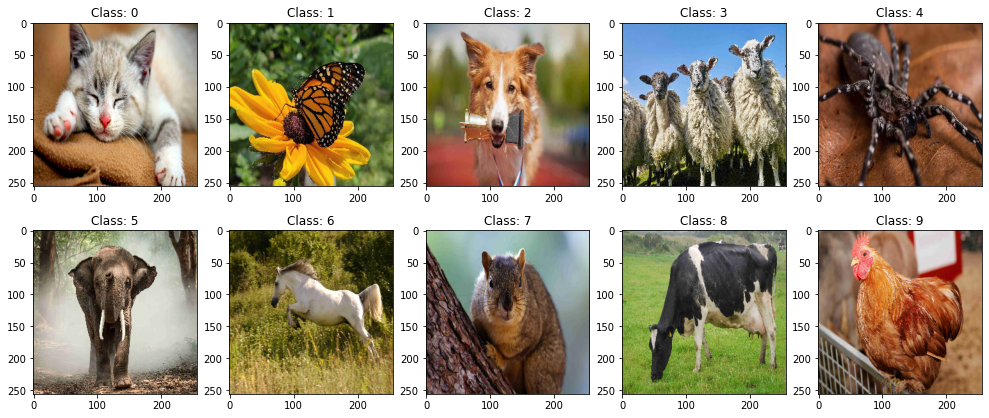

In [ ]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(17, 7))
cols, rows = 5, 2

for i in range(10):
  
  figure.add_subplot(rows, cols, i+1)
  plt.title("Class: "+str(label[0+229*i]))
  plt.imshow(imgs[0+229*i])
plt.show()  

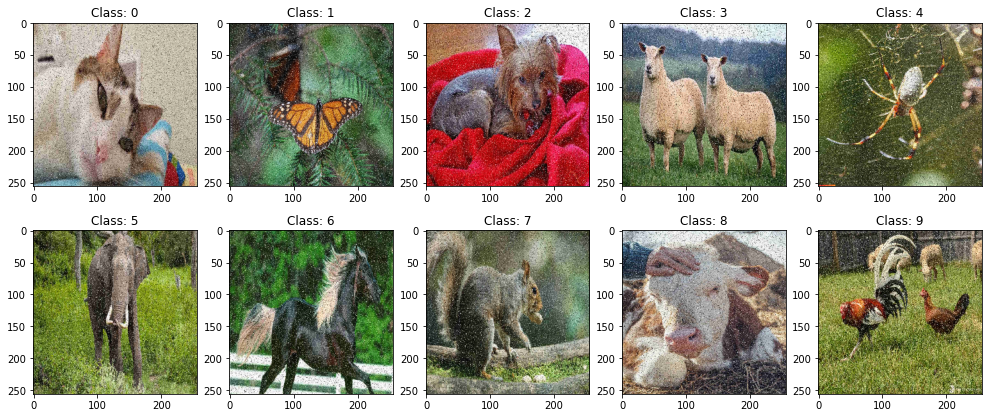

In [ ]:
#imgs with salt and pepper noise
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(17, 7))
cols, rows = 5, 2

for i in range(10):
  
  figure.add_subplot(rows, cols, i+1)
  plt.title("Class: "+str(label[200+229*i]))
  plt.imshow(imgs[200+229*i])
plt.show()  

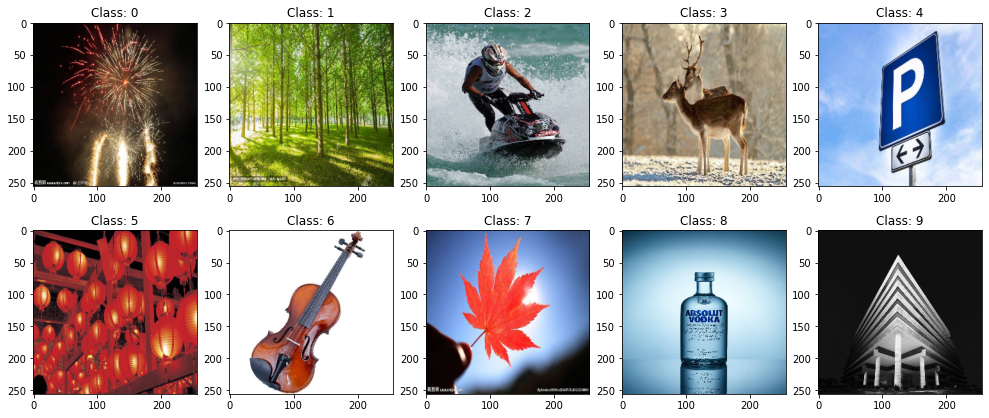

In [ ]:
#image with other noise
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(17, 7))
cols, rows = 5, 2

for i in range(10):
  
  figure.add_subplot(rows, cols, i+1)
  plt.title("Class: "+str(label[226+229*i]))
  plt.imshow(imgs[226+229*i])
plt.show()  

#### 1.4: Train Test Split

In [4]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split

In [5]:
imgs=np.load('./4155data/imgs_animal10.npy')
label=np.load('./4155data/label_animal10.npy')

In [6]:
X_train, X_test, y_train, y_test = train_test_split(imgs, label, test_size=0.33, random_state=16,stratify=label)
y_train = to_categorical(y_train) 
y_test = to_categorical(y_test)


In [7]:
imgs=np.load('./4155data/imgs_bing.npy')
label=np.load('./4155data/label_bing.npy')

In [8]:
X_eval=imgs
y_eval=to_categorical(label)

### Section 2: Refine CNN Model

#### A.cnn with tanh

In [18]:
#A.cnn with tanh 
from keras import optimizers
from keras.layers import Input,Rescaling
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,Dropout,BatchNormalization
from keras.models import Sequential
model = Sequential()

model.add(Input(shape=(224, 224, 3)))
model.add(Rescaling(1./255))
model.add(Conv2D(32, kernel_size = 3, activation='tanh'))

model.add(Conv2D(32, kernel_size = 3, activation='tanh'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='tanh'))


model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='tanh'))


model.add(Flatten())


model.add(Dense(128, activation='tanh'))
model.add(Dense(10, activation='softmax'))  

# model summary
print(model.summary())
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

train_history = model.fit(X_train,y_train,epochs=15,batch_size=64,verbose=1)
print("---------test---------")
loss,acc = model.evaluate(X_test,y_test)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 conv2d_18 (Conv2D)          (None, 220, 220, 32)      9248      
                                                                 
 batch_normalization_14 (Bat  (None, 220, 220, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_19 (Conv2D)          (None, 110, 110, 32)      25632     
                                                                 
 conv2d_20 (Conv2D)          (None, 55, 55, 64)        51264     
                                                      

In [19]:
print("---------evaluation---------")
loss,acc = model.evaluate(X_eval,y_eval)

---------evaluation---------
70/70 [==============================] - 2s 23ms/step - loss: 2.3993 - accuracy: 0.1138


#### A.cnn with tanh,6 layer 

In [10]:
#A.cnn with tanh 6 layer 
from keras import optimizers
from keras.layers import Input,Rescaling
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,Dropout,BatchNormalization
from keras.models import Sequential
model = Sequential()

model.add(Input(shape=(224, 224, 3)))
model.add(Rescaling(1./255))
model.add(Conv2D(32, kernel_size = 3, activation='tanh'))

model.add(Conv2D(32, kernel_size = 3, activation='tanh'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 3, strides=2, padding='same', activation='tanh'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 3, strides=2, padding='same', activation='tanh'))
model.add(Conv2D(32, kernel_size = 3, strides=2, padding='same', activation='tanh'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='tanh'))


model.add(Flatten())


model.add(Dense(128, activation='tanh'))
model.add(Dense(10, activation='softmax'))  

# model summary
print(model.summary())
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

train_history = model.fit(X_train,y_train,epochs=15,batch_size=64,verbose=1)
print("---------test---------")
loss,acc = model.evaluate(X_test,y_test)
print("---------evaluation set---------")
loss,acc = model.evaluate(X_eval,y_eval)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 220, 220, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 220, 220, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_8 (Conv2D)           (None, 110, 110, 32)      9248      
                                                                 
 batch_normalization_2 (Batc  (None, 110, 110, 32)     128       
 hNormalization)                                      

#### A.cnn with relu dropout

In [ ]:
from keras import optimizers
from keras.layers import Input,Rescaling
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,Dropout,BatchNormalization
from keras.models import Sequential
model = Sequential()

model.add(Input(shape=(224, 224, 3)))
model.add(Rescaling(1./255))
model.add(Conv2D(32, kernel_size = 3, activation='relu'))

model.add(Conv2D(32, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))

model.add(Dropout(0.4))
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))


model.add(Flatten())
model.add(Dropout(0.4))

model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))  

# model summary
print(model.summary())
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

train_history = model.fit(X_train,y_train,epochs=15,batch_size=64,verbose=1)
print("---------test---------")
loss,acc = model.evaluate(X_test,y_test)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 220, 220, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 110, 110, 32)      25632     
                                                                 
 dropout (Dropout)           (None, 110, 110, 32)      0         
                                                        

In [ ]:

print("---------evaluation set---------")
loss,acc = model.evaluate(X_eval,y_eval)

---------evaluation set---------
70/70 [==============================] - 1s 18ms/step - loss: 4.3284 - accuracy: 0.3344


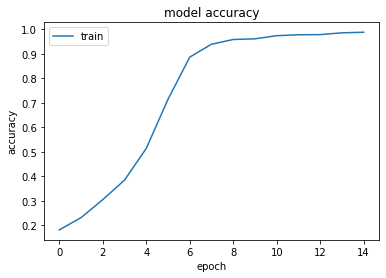

In [ ]:
plt.plot(train_history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()


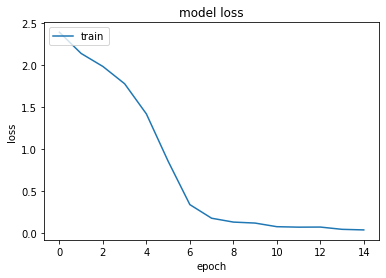

In [ ]:
plt.plot(train_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

### Section 3: ALexNet

In [ ]:
from keras.layers import BatchNormalization,MaxPooling2D
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,Dropout
from keras.models import Sequential
from keras.layers import Input,Rescaling
model = Sequential()
model.add(Input(shape=(224, 224, 3)))
model.add(Rescaling(1./255))
model.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='valid',kernel_initializer='uniform',activation='relu'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same",kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same",kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same",kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same",kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

print(model.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization_6 (Batc  (None, 54, 54, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 26, 26, 96)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 26, 26, 256)       614656    
                                                                 
 batch_normalization_7 (Batc  (None, 26, 26, 256)     

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

train_history = model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
275/275 [==============================] - 11s 37ms/step - loss: 3.5842 - accuracy: 0.2338
Epoch 2/100
275/275 [==============================] - 10s 37ms/step - loss: 2.0158 - accuracy: 0.3156
Epoch 3/100
275/275 [==============================] - 10s 37ms/step - loss: 1.8683 - accuracy: 0.3610
Epoch 4/100
275/275 [==============================] - 10s 37ms/step - loss: 1.7671 - accuracy: 0.4049
Epoch 5/100
275/275 [==============================] - 10s 37ms/step - loss: 1.6912 - accuracy: 0.4301
Epoch 6/100
275/275 [==============================] - 10s 37ms/step - loss: 1.6280 - accuracy: 0.4529
Epoch 7/100
275/275 [==============================] - 10s 37ms/step - loss: 1.5028 - accuracy: 0.4975
Epoch 8/100
275/275 [==============================] - 10s 37ms/step - loss: 1.4487 - accuracy: 0.5219
Epoch 9/100
275/275 [==============================] - 10s 37ms/step - loss: 1.3834 - accuracy: 0.5391
Epoch 10/100
275/275 [==============================] - 10s 37ms/step - l

In [ ]:
print("---------test---------")
loss,acc = model.evaluate(X_test,y_test)

---------test---------
270/270 [==============================] - 3s 9ms/step - loss: 1.4622 - accuracy: 0.7655


In [ ]:
print("---------evaluation on crawled data---------")
loss,acc = model.evaluate(X_eval,y_eval)

---------evaluation on crawled data---------
70/70 [==============================] - 1s 9ms/step - loss: 2.2762 - accuracy: 0.6263


### Section 4: VGG

#### without batchnorm

In [9]:
from keras.layers import BatchNormalization,MaxPooling2D
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten,Dropout
from keras.models import Sequential
from keras.layers import Input,Rescaling
model=Sequential()
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=10, activation="softmax"))

print(model.summary())
from tensorflow import keras
from keras import optimizers

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

train_history = model.fit(X_train,y_train,epochs=30,batch_size=64,verbose=1)
print("---------test---------")
loss,acc = model.evaluate(X_test,y_test)
print("---------evaluation set---------")
loss,acc = model.evaluate(X_eval,y_eval)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

#### vgg batchnorm

In [ ]:
from keras.layers import BatchNormalization,MaxPooling2D
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten,Dropout
from keras.models import Sequential
from keras.layers import Input,Rescaling
model=Sequential()
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=10, activation="softmax"))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                      

In [ ]:
from tensorflow import keras
from keras import optimizers

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

train_history = model.fit(X_train,y_train,epochs=30,batch_size=64,verbose=1)

Epoch 1/30
275/275 [==============================] - 148s 485ms/step - loss: 6.1471 - accuracy: 0.2851
Epoch 2/30
275/275 [==============================] - 133s 483ms/step - loss: 2.0417 - accuracy: 0.3847
Epoch 3/30
275/275 [==============================] - 133s 483ms/step - loss: 1.6685 - accuracy: 0.4555
Epoch 4/30
275/275 [==============================] - 133s 483ms/step - loss: 1.4882 - accuracy: 0.5089
Epoch 5/30
275/275 [==============================] - 133s 483ms/step - loss: 1.3648 - accuracy: 0.5416
Epoch 6/30
275/275 [==============================] - 133s 483ms/step - loss: 1.2272 - accuracy: 0.5873
Epoch 7/30
275/275 [==============================] - 133s 483ms/step - loss: 1.1048 - accuracy: 0.6400
Epoch 8/30
275/275 [==============================] - 133s 484ms/step - loss: 1.0001 - accuracy: 0.6669
Epoch 9/30
275/275 [==============================] - 133s 483ms/step - loss: 0.8993 - accuracy: 0.7011
Epoch 10/30
275/275 [==============================] - 133s 483m

In [ ]:
print("---------test---------")
loss,acc = model.evaluate(X_test,y_test)

---------test---------
270/270 [==============================] - 19s 69ms/step - loss: 2.2576 - accuracy: 0.6567


In [14]:
print("---------evaluation set---------")
loss,acc = model.evaluate(X_eval,y_eval)

---------test---------
70/70 [==============================] - 5s 70ms/step - loss: 4.0100 - accuracy: 0.4835
